# Checking motif overlap
We want to see, for motifs that appear enriched in CND, if they are also present in ATL. We used `annotatePeaks.pl` from HOMER for the heavy lifting here; we now just need to read in the inputs and summarize them.

In [1]:
from os import listdir
from os.path import splitext, isfile, abspath
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from scipy.stats import fisher_exact, false_discovery_control
import matplotlib.pyplot as plt
from itertools import product
import json
import logomaker

## Reading in the data
Data are stored as tab-delimited files. However, most of the rows are empty of useful information; each file contains every promoter in the entire ATL genome, with only a few rows containing something in the column that shows motif matches. Unfortunately that column does not have a consisten name; however, it is always the last one. Additionally, the RV motif output files should be semantically identical to the forward ones, with the possible exception of the sequence being flipped in the macthed motif. We will conserve both for the moment in order to check them later.

In [2]:
data_dir = '../data/outputs/annotated_motifs/CND_searching_ATL_timey_background_ShD_500_start_07May2025/'
motif_matches = defaultdict(dict)
for f in tqdm(listdir(data_dir)):
    if isfile(f'{data_dir}/{f}'):
        module = '_'.join(splitext(f)[0].split('_')[:2])
        motif = splitext(f)[0].split('_')[2]
        try:
            df = pd.read_csv(f'{data_dir}/{f}', sep='\t', header=0)
            motif_matches[module][motif] = df
        except pd.errors.EmptyDataError:
            print(f'Empty data error for file: {f}')
        except pd.errors.ParserError:
            print(f'Parser error for file: {f}')

  3%|██▍                                                                              | 35/1137 [00:21<11:22,  1.61it/s]/tmp/ipykernel_404856/199891303.py:8: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/{f}', sep='\t', header=0)
 15%|████████████                                                                    | 171/1137 [01:42<09:29,  1.70it/s]/tmp/ipykernel_404856/199891303.py:8: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/{f}', sep='\t', header=0)
 33%|██████████████████████████▌                                                     | 378/1137 [03:44<07:29,  1.69it/s]/tmp/ipykernel_404856/199891303.py:8: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/{f}', sep='\t', header=0)
 33%|██████████████████████████▋                 

### Check that the forward and reverse identifications are the same
There are two main things to check: first, that the same rows are present in the dataframe, and second, that the identified sequences are either identical or just reverse complements. But first, did every motif have a reverse complement checked?

In [3]:
no_rev = 0
mismatch = 0
for module, motifs in motif_matches.items():
    for motif, df in motifs.items():
        if 'RV' not in motif:
            rev_motif = motif + 'RV'
            if rev_motif not in motifs.keys():
                no_rev += 1
            else:
                # Check if the contents are the same
                try:
                    # Rather than checking entire df, just check if the gene names with
                    # non-NaN in the column of interest are the same
                    gset1 = set(motifs[motif][~motifs[motif].iloc[:, -1].isna()].iloc[:, 0].tolist())
                    gset2 = set(motifs[rev_motif][~motifs[rev_motif].iloc[:, -1].isna()].iloc[:, 0].tolist())
                    assert gset1 == gset2
                except AssertionError as e:
                    mismatch += 1

In [4]:
no_rev, mismatch

(0, 0)

The reverses and the forward do in fact identify the same genes! This means we can remove any items that have RV in the motif name:

In [5]:
motif_matches_forward_only = {
    mod: {mot: v for mot, v in motifs.items() if 'RV' not in mot}
    for mod, motifs in motif_matches.items()
}

### Reading in the module data
We also need to check whether or not the matches are within the same module, so we need to read in the module memberships. We need to replace underscores with periods here to match the values in the gene ID column of our motif matching results:

In [6]:
module_base_path = '/home/farre/Ann/RNAseq/HOMER_analysis/queries/shd_pca_modulesapril2024'
module_members = {'ATL': {}, 'CND': {}}
for module in listdir(module_base_path):
    if 'ATL_ShD_Leaf_vs_CND_ShD_Leaf_' in module and '.txt' in module:
        module_basename = splitext(module)[0][len('ATL_ShD_Leaf_vs_CND_ShD_Leaf_'):-len('_in_XXX')]
        species = splitext(module)[0][-3:]
        with open(f'{module_base_path}/{module}') as f:
            module_genes = [l.strip() for l in f.readlines()]
        module_genes = [s[:s.rfind('_')] + '.' + s[s.rfind('_')+1:] for s in module_genes]
        module_members[species][module_basename] = module_genes

For our Fisher's Exact test we'll also need a complete list of the genes in all modules for ATL.

In [7]:
all_module_genes_ATL = []
for mod, members in module_members['ATL'].items():
    all_module_genes_ATL += members

## Motif matching
Now we go through each module's motif matches and see how many genes within that module have motif matches. We searched ATL with the motifs we identified in CND, so we will need the ATL gene ID's.

In [8]:
fisher_cats = defaultdict(dict)
for module, results in motif_matches_forward_only.items():
    print(f'On module {module} of {len(motif_matches_forward_only)}')
    for motif, matches in tqdm(results.items(), leave=False):
        in_module = matches[matches.iloc[:, 0].isin(module_members['ATL'][module])]
        in_mod_w_motif = in_module[~in_module.iloc[:, -1].isna()]
        in_mod_wo_motif = in_module[in_module.iloc[:, -1].isna()]
        out_mod = [g for g in all_module_genes_ATL if g not in in_module.iloc[:, 0].tolist()]
        out_mod_all = matches[matches.iloc[:, 0].isin(out_mod)]
        out_mod_w_motif = out_mod_all[~out_mod_all.iloc[:, -1].isna()]
        out_mod_wo_motif = out_mod_all[out_mod_all.iloc[:, -1].isna()]
        fisher_cats[module][motif] = {
            'in_mod_with_motif': in_mod_w_motif,
            'in_mod_without_motif': in_mod_wo_motif,
            'out_mod_with_motif': out_mod_w_motif,
            'out_mod_without_motif': out_mod_wo_motif
        }

On module module_0 of 18


On module module_1 of 18


On module module_2 of 18


On module module_25 of 18


On module module_26 of 18


On module module_27 of 18


On module module_28 of 18


On module module_29 of 18


On module module_3 of 18


On module module_30 of 18


On module module_31 of 18


On module module_32 of 18


On module module_34 of 18


On module module_4 of 18


On module module_42 of 18


On module module_5 of 18


On module module_6 of 18


On module module_77 of 18


## Statistical testing
We now want to perform a Fisher's exact test on each motif/module combination to see if it's enriched in ATL in addition to CND (which we already know from the HOMER analysis). Fisher's will also test positive if the motif appears many times in one group and none in the other, so we will have to visually check the contingecy tables for those that are statistically significant.

First, get the contingency tables:

In [9]:
fisher_numbers = {
    mod: {
        motif: [[len(m['in_mod_with_motif']), len(m['in_mod_without_motif'])], [len(m['out_mod_with_motif']), len(m['out_mod_without_motif'])]]
         for motif, m in motifs.items()    
    }
    
    for mod, motifs in fisher_cats.items()
}

Perform the test:

In [10]:
fisher_results = {
    mod: {
        motif: fisher_exact(table, alternative='greater') for motif, table in motifs.items()
    }
    for mod, motifs in fisher_numbers.items()
}

We need to apply a multiple testing correction, which we'll do with `scipy.stats.false_discovery_control` using the `Benjaminini-Yekutieli` correction. First, we need to flatten the results so we can provide a 1D array of p-values to be corrected.

In [11]:
to_correct = []
to_correct_names = []
for module, motifs in fisher_results.items():
    for motif, res in motifs.items():
        to_correct.append(res[1])
        to_correct_names.append(module + '_' + motif)

Now apply the correction:

In [12]:
corrected_ps = false_discovery_control(to_correct, method='by')

How much did this impact the number of motifs per module that come back significant?

In [13]:
len([p for p in to_correct if p < 0.05]), len([p for p in corrected_ps if p < 0.05])

(467, 360)

Filter out the non-significant results as we combine the names and p-values again:

In [14]:
corrected_p_results = {cn: cp for cn, cp in zip(to_correct_names, corrected_ps) if cp < 0.05}

## Cross-module comparisons
While we've been able to somewhat narrow down the number of motifs of interest by checking if they're also enriched in the same module in ATL as in CND where they were identified, we still have a prohibitively large number of motifs. Another way we can narrow these down is to consider that we want motifs that appear in multiple modules. In particular, we want to identify motifs that appear in multiple "shifted" modules, where shifting means that ATL is late compared to CND, which is our phenotype of interest. To do this, we'll take a similar approach as above, but instead of checking the motifs within their original modules, we will also check them across other modules. We will only consider those that tested significant in the previous section.

To make this easier, flatten all the data by making composite names containing both module and motif numbers:

In [15]:
flattened_matched_motifs = {f'{module}_{motif}': matches for module, motifs in motif_matches_forward_only.items() for motif, matches in motifs.items() if f'{module}_{motif}' in corrected_p_results.keys()}
len(flattened_matched_motifs)

360

We now need every pairwise comparison of module and motif, and to create the Fisher's contingency table for each of these comparisons.

In [16]:
module_names = list(motif_matches_forward_only.keys())
motif_names = list(flattened_matched_motifs.keys())

I'm going to streamline the process of creating the contingency table and doing the testing so we don't need to loop over all the combinations multiple times:

In [17]:
cross_fisher_results = {}
for module, motif in tqdm(product(module_names, motif_names)):
    matches = flattened_matched_motifs[motif]
    in_module = matches[matches.iloc[:, 0].isin(module_members['ATL'][module])]
    in_mod_w_motif = len(in_module[~in_module.iloc[:, -1].isna()])
    in_mod_wo_motif = len(in_module[in_module.iloc[:, -1].isna()])
    out_mod = [g for g in all_module_genes_ATL if g not in in_module.iloc[:, 0].tolist()]
    out_mod_all = matches[matches.iloc[:, 0].isin(out_mod)]
    out_mod_w_motif = len(out_mod_all[~out_mod_all.iloc[:, -1].isna()])
    out_mod_wo_motif = len(out_mod_all[out_mod_all.iloc[:, -1].isna()])
    contingency_table = [[in_mod_w_motif, in_mod_wo_motif], [out_mod_w_motif, out_mod_wo_motif]]
    fisher_res = fisher_exact(contingency_table, alternative='greater')
    cross_fisher_results[f'{module}__{motif}'] = fisher_res

6480it [1:26:46,  1.24it/s]


Save the results so we don't need to run it again:

In [18]:
with open('../data/statistical_testing/13May2025_cross_module_fisher_start_500.json', 'w') as f:
    json.dump(cross_fisher_results, f)

Perform multiple testing correction:

In [19]:
cross_ps = [res[1] for res in cross_fisher_results.values()]
corrected_cross_ps = false_discovery_control(cross_ps, method='by')
corrected_cross_ps_dict = {k: p for k, p in zip(cross_fisher_results.keys(), corrected_cross_ps) if p < 0.05}

Impact of the correction:

In [20]:
len([p for p in cross_ps if p < 0.05]), len([p for p in corrected_cross_ps if p < 0.05])

(719, 265)

We now need to check for the presence of these motifs in the modules that are shifted in ATL. THese are modules with a mean lag of greater than 0.75. First, let's read in the lag data:

In [21]:
module_lags = pd.read_csv('/home/farre/Ann/RNAseq/for_serena/module_results/ATL_ShD_Leaf_vs_CND_ShD_Leaf_module_averages_correlations.csv')
module_lags.head()

,module,mean_lag,lag_std,lag,corr,Avgs_Diff
0,0,5.792000,1.704860,6,1.024301,-0.208000
1,1,3.589242,3.601128,6,0.779887,-2.410758
2,2,2.756677,3.218191,4,0.763333,-1.243323
3,3,6.290618,1.320463,6,1.020063,0.290618
4,4,3.015656,1.946832,4,1.047411,-0.984344


In [22]:
modules_to_check = [f'module_{module}' for module in module_lags[module_lags.mean_lag > 0.75].module.tolist()]

The crosschecked p-values also contain the same within-module checks that we already performed, so let's remove any where the module in the module and the module in the motif are the same. How many are we left with?

In [23]:
corrected_cross_ps_dict = {k:v for k, v in corrected_cross_ps_dict.items() if k.split('_')[1] != k.split('_')[4]}

In [24]:
len(corrected_cross_ps_dict)

26

This is a manageable number of motifs! For each motif, what is the proportion of modules it appears in that are shifted?

In [25]:
motif_to_mod = defaultdict(list)
for k in corrected_cross_ps_dict:
    mod, motif = k.split('__')
    motif_to_mod[motif].append(mod)

In [26]:
print(f'The maximum number of modules any one motif appears enriched in is {max([len(v) for v in motif_to_mod.values()])}')

The maximum number of modules any one motif appears enriched in is 2


In [27]:
prop_shifted = {k: len([mod for mod in v if mod in modules_to_check])/len(v) for k, v in motif_to_mod.items()}

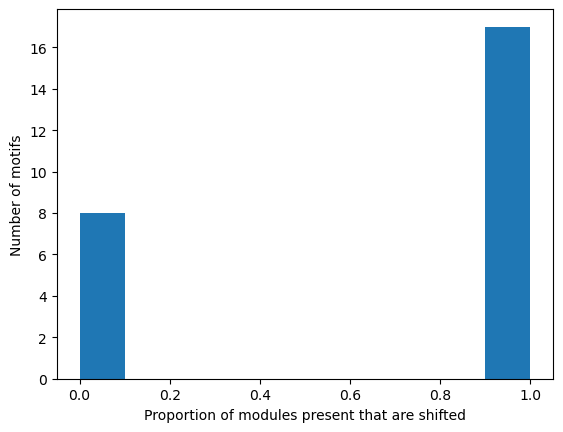

In [28]:
_ = plt.hist(prop_shifted.values())
_ = plt.xlabel('Proportion of modules present that are shifted')
_ = plt.ylabel('Number of motifs')

Now what happens if we remove motifs that aren't present in any shifted modules?

In [29]:
motifs_of_interest = {m: motif_to_mod[m] for m, v in prop_shifted.items() if v > 0}

In [30]:
motifs_of_interest

{'module_25_motif13': ['module_1'],
 'module_25_motif1': ['module_1'],
 'module_42_motif7': ['module_1'],
 'module_6_motif10': ['module_1'],
 'module_1_motif9': ['module_2'],
 'module_32_motif2': ['module_2'],
 'module_34_motif2': ['module_2'],
 'module_27_motif17': ['module_26'],
 'module_28_motif29': ['module_26', 'module_27'],
 'module_28_motif35': ['module_26'],
 'module_0_motif15': ['module_3'],
 'module_0_motif16': ['module_3'],
 'module_1_motif1': ['module_34'],
 'module_2_motif1': ['module_34'],
 'module_31_motif24': ['module_34'],
 'module_29_motif30': ['module_6'],
 'module_25_motif9': ['module_77']}

Interestingly, we don't really see what we would expect, where a single motif would appear in multiple modules; however, modules 26 and 34 appear to have multiple motifs that are enriched.

Finally, we need to check to see if these motifs are also enriched in the same pair of modules in CND as they are in ATL. For example, `module_30_motif22` is enriched in CND module 30, and in ATL module 0; but we need to check if it's also enriched in CND module 0 and ATL module 30. We already know that the motif is enriched in the "home" module in ATL, because we started with only those that were significantly enriched in ATL. However, we haven't checked if it's also enriched in CND module 0. We'll do that by running `annotatePeaks.pl` again, and reading in the results here.

In [31]:
data_dir = '../data/outputs/annotated_motifs/CND_searching_CND_timey_background_ShD__cross_motif_check_500_start_07May2025'
CND_searching_CND_motif_matches = defaultdict(dict)
for f in tqdm(listdir(data_dir)):
    if isfile(f'{data_dir}/{f}'):
        composite_motif_name = f.split('_CND')[0]
        if 'RV' not in composite_motif_name:
            df = pd.read_csv(f'{data_dir}/{f}', sep='\t', header=0)
            CND_searching_CND_motif_matches[composite_motif_name] = df

 33%|██████████████████████████▌                                                     | 377/1136 [00:26<00:53, 14.26it/s]/tmp/ipykernel_404856/1762987794.py:7: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/{f}', sep='\t', header=0)
 69%|███████████████████████████████████████████████████████▍                        | 787/1136 [00:56<00:27, 12.93it/s]/tmp/ipykernel_404856/1762987794.py:7: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/{f}', sep='\t', header=0)
 95%|██████████████████████████████████████████████████████████████████████████▊    | 1075/1136 [01:19<00:04, 12.38it/s]/tmp/ipykernel_404856/1762987794.py:7: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/{f}', sep='\t', header=0)
 97%|█████████████████████████████████████████

Get all the genes in all modules together for CND:

In [32]:
all_module_genes_CND = []
for mod, members in module_members['CND'].items():
    all_module_genes_CND += members

Go through just the motifs of interest to see if they're cross-enriched in CND:

In [33]:
CND_cross_results = defaultdict(list)
for motif, crossmods in tqdm(motifs_of_interest.items()):
    matches = CND_searching_CND_motif_matches[motif]
    for module in crossmods:
        in_module = matches[matches.iloc[:, 0].isin(module_members['CND'][module])]
        in_mod_w_motif = len(in_module[~in_module.iloc[:, -1].isna()])
        in_mod_wo_motif = len(in_module[in_module.iloc[:, -1].isna()])
        out_mod = [g for g in all_module_genes_CND if g not in in_module.iloc[:, 0].tolist()]
        out_mod_all = matches[matches.iloc[:, 0].isin(out_mod)]
        out_mod_w_motif = len(out_mod_all[~out_mod_all.iloc[:, -1].isna()])
        out_mod_wo_motif = len(out_mod_all[out_mod_all.iloc[:, -1].isna()])
        contingency_table = [[in_mod_w_motif, in_mod_wo_motif], [out_mod_w_motif, out_mod_wo_motif]]
        fisher_res = fisher_exact(contingency_table, alternative='greater')
        CND_cross_results[f'{module}__{motif}'] = fisher_res

100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [00:09<00:00,  1.71it/s]


Do a quick multiple test correction:

In [34]:
CND_cross_results_corrected = {
    k: corr_v for k, corr_v in zip(CND_cross_results.keys(), false_discovery_control([v[1] for v in CND_cross_results.values()], method='by'))
}

Get the ones that are significant:

In [35]:
motifs_sig_in_all = defaultdict(list)
for mod_motif, corr_p in CND_cross_results_corrected.items():
    module, motif = mod_motif.split('__')
    if corr_p < 0.05:
        motifs_sig_in_all[motif].append(module)

In [36]:
motifs_sig_in_all

defaultdict(list,
            {'module_25_motif13': ['module_1'],
             'module_25_motif1': ['module_1'],
             'module_42_motif7': ['module_1'],
             'module_6_motif10': ['module_1'],
             'module_32_motif2': ['module_2'],
             'module_28_motif29': ['module_27'],
             'module_28_motif35': ['module_26']})

Map the old module names to new module names for the ones significant in 3 and those significant in all:

In [37]:
module_mapper = pd.read_csv('../data/ATL ShD Leaf vs CND ShD Leaf_reorder_key.csv', index_col=0)
module_mapper

,module,new_module
0,30,1
1,31,2
2,29,3
3,28,4
4,26,5
5,4,6
6,27,7
7,3,8
8,2,9
9,34,10


In [38]:
module_mapper = module_mapper.set_index('module').to_dict()['new_module']

In [39]:
motifs_of_interest_new_names = {}
for motif, modules in motifs_of_interest.items():
    new_motif_name = 'module_' + str(module_mapper[int(motif.split('_')[1])]) + '_' + motif.split('_')[2]
    new_module_names = ['module_' + str(module_mapper[int(mod.split('_')[1])]) for mod in modules]
    motifs_of_interest_new_names[new_motif_name] = new_module_names

In [40]:
motifs_sig_in_all_new_names = {}
for motif, modules in motifs_sig_in_all.items():
    new_motif_name = 'module_' + str(module_mapper[int(motif.split('_')[1])]) + '_' + motif.split('_')[2]
    new_module_names = ['module_' + str(module_mapper[int(mod.split('_')[1])]) for mod in modules]
    motifs_sig_in_all_new_names[new_motif_name] = new_module_names

In [41]:
motifs_of_interest_new_names

{'module_11_motif13': ['module_14'],
 'module_11_motif1': ['module_14'],
 'module_15_motif7': ['module_14'],
 'module_16_motif10': ['module_14'],
 'module_14_motif9': ['module_9'],
 'module_12_motif2': ['module_9'],
 'module_10_motif2': ['module_9'],
 'module_7_motif17': ['module_5'],
 'module_4_motif29': ['module_5', 'module_7'],
 'module_4_motif35': ['module_5'],
 'module_13_motif15': ['module_8'],
 'module_13_motif16': ['module_8'],
 'module_14_motif1': ['module_10'],
 'module_9_motif1': ['module_10'],
 'module_2_motif24': ['module_10'],
 'module_3_motif30': ['module_16'],
 'module_11_motif9': ['module_17']}

In [42]:
motifs_sig_in_all_new_names

{'module_11_motif13': ['module_14'],
 'module_11_motif1': ['module_14'],
 'module_15_motif7': ['module_14'],
 'module_16_motif10': ['module_14'],
 'module_12_motif2': ['module_9'],
 'module_4_motif29': ['module_7'],
 'module_4_motif35': ['module_5']}

## TODO: merged modules

## Visualizing motifs of interest
Now that we have these results, we also want to know if any of the motifs of interest are similar to one another. We can evaluate this manually by plotting the motif diagrams and manually comparing them.

In [43]:
def load_binding(path, remove=True):
    # From Ann
    # path should be to a file in the HOMER motif format, which is tab-separated
    # the first row is a header (ignored)
    # the rest are the position weights for A, C, G, and T
    # "remove" (the fifth column) is empty; if your file doesn't have this, set remove to False
    cols = ["A","C","G","T"]
    if remove == True:
        cols.append("remove")
    df = pd.read_csv(path, sep="\t", header=None,skiprows=1,names=cols)
    if remove == True:
        df = df.drop("remove", axis=1)
    df.reset_index(names="position", inplace=True)
    return df

def make_logo(motif, motif_name, appears_in):
    # From Ann
    # motif is a df with the columns of "A" "C" "G" and "T"
    # optional columns include "position"
    if "position" in motif.columns:
        motif.set_index("position", inplace=True)
    num_bases = int(motif.index.max())
    # print(num_bases)
    motif_t = logomaker.transform_matrix(motif, from_type="probability", to_type="information")
    logo = logomaker.Logo(motif_t, figsize=(num_bases, 2.5))
    ax = plt.gca()
    ax.axis("off")
    ax.set_title(f'{motif_name}, appears in: {appears_in}')

in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...


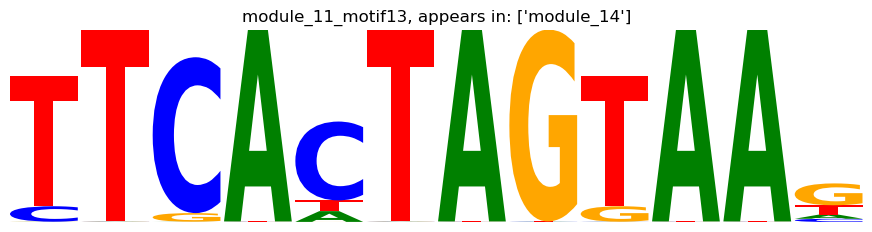

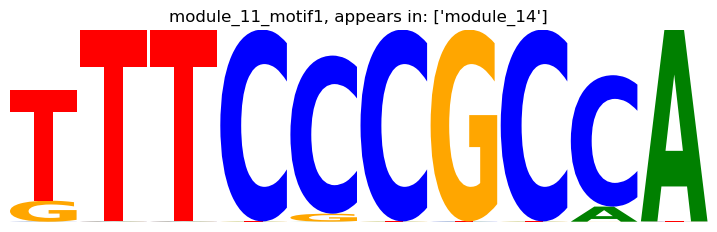

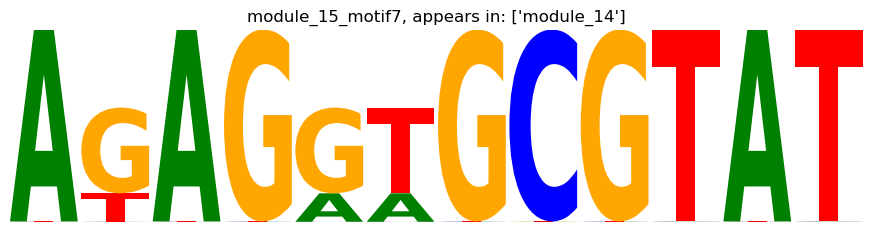

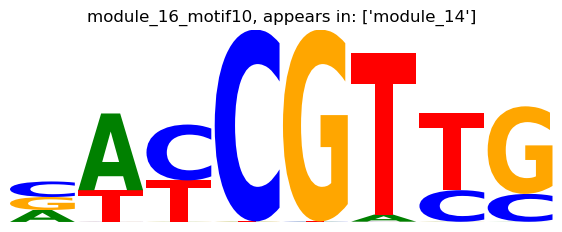

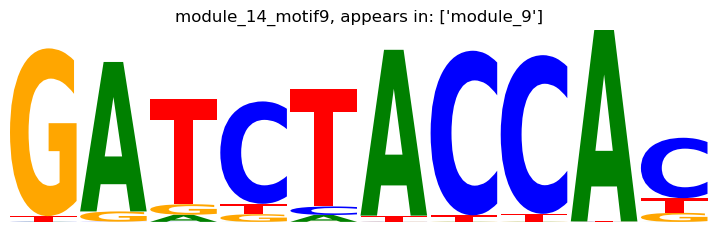

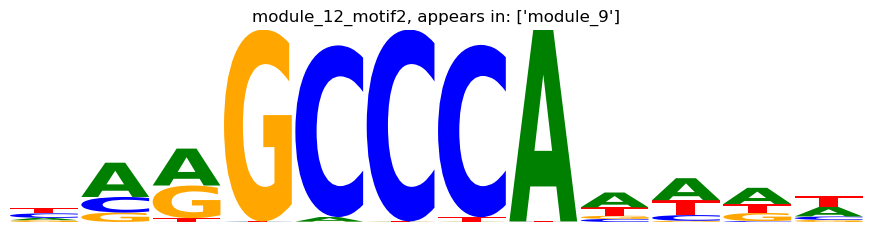

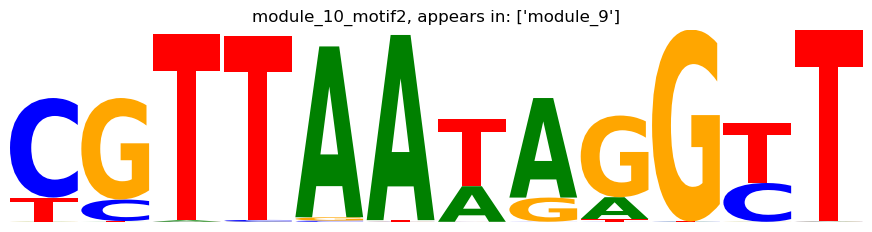

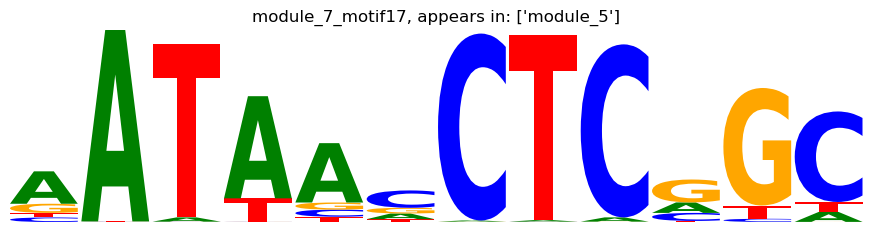

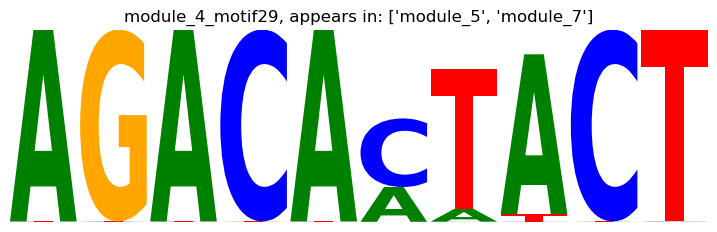

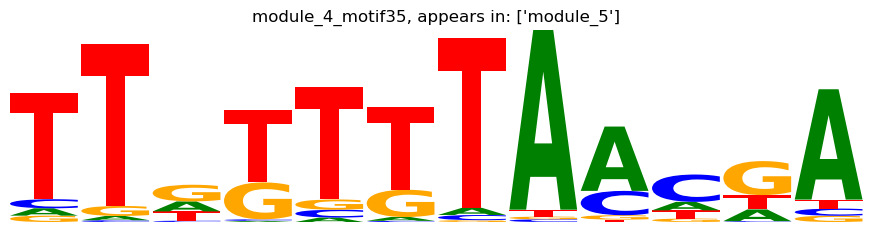

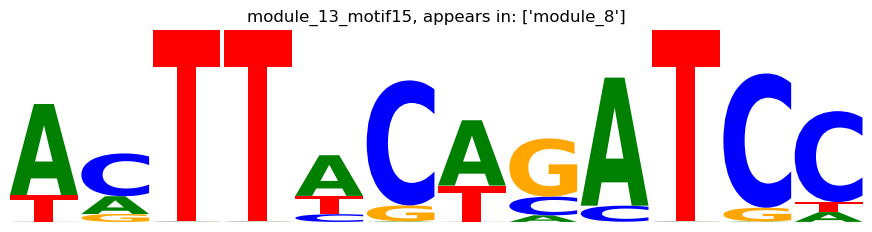

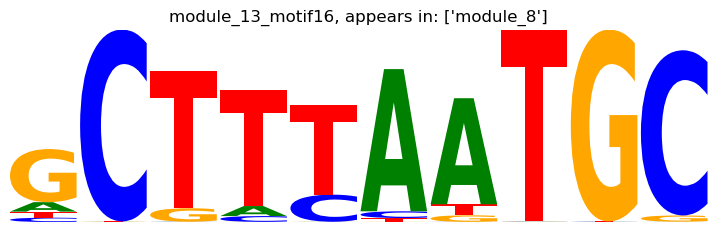

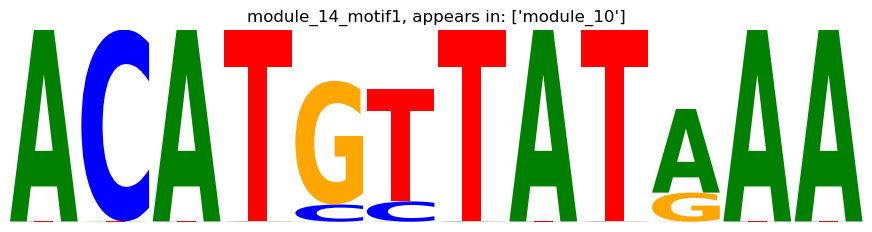

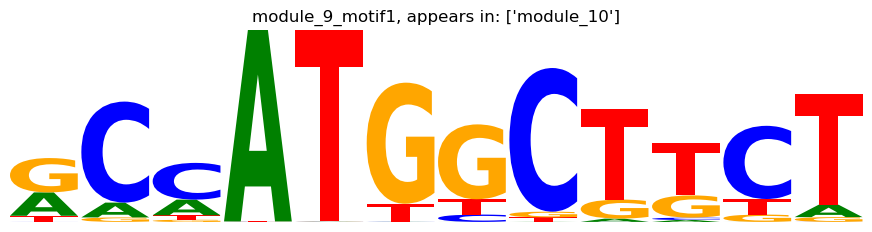

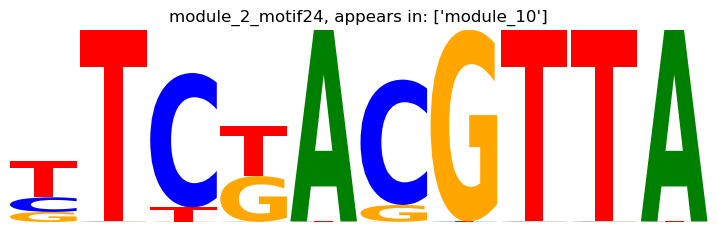

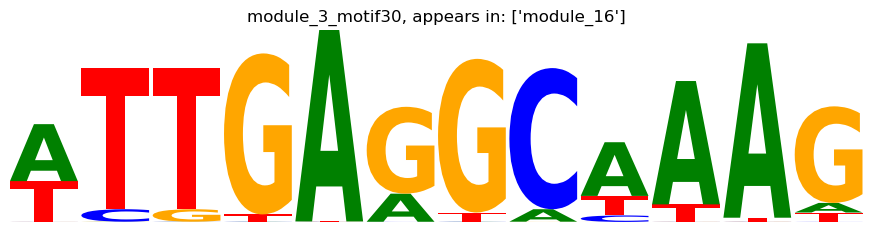

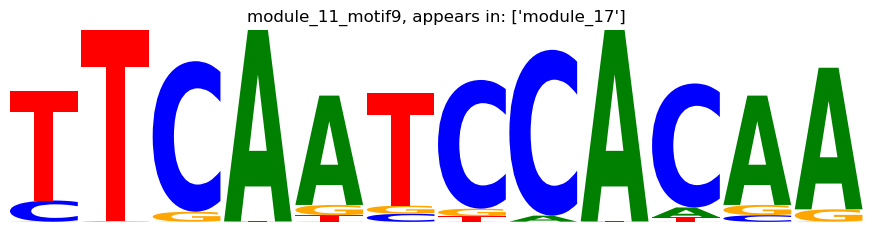

In [44]:
for motif, appears_in in motifs_of_interest.items():
    mod = '_'.join(motif.split('_')[:2])
    motif_base = motif.split('_')[-1]
    # Get the binding
    motif_rep = load_binding(f'../data/outputs/ATL_CND_ShD_Leaf_timey_backgrounds/ATL_ShD_Leaf_vs_CND_ShD_Leaf/{mod}/CND/homerResults/{motif_base}.motif')
    # Plot
    motif_title = 'module_' + str(module_mapper[int(motif.split('_')[1])]) + '_' + motif.split('_')[2]
    appears_in_new = [f'module_{module_mapper[int(m.split("_")[1])]}' for m in appears_in]
    make_logo(motif_rep, motif_title, appears_in_new)

in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...


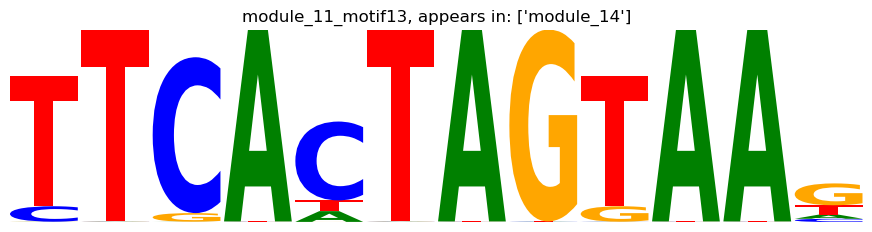

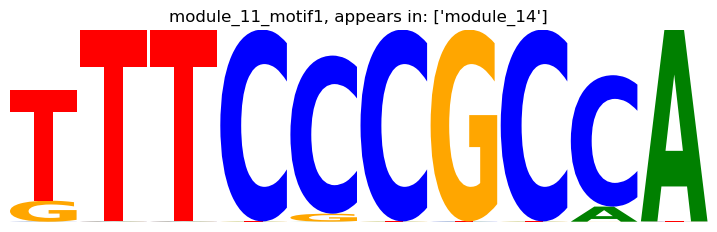

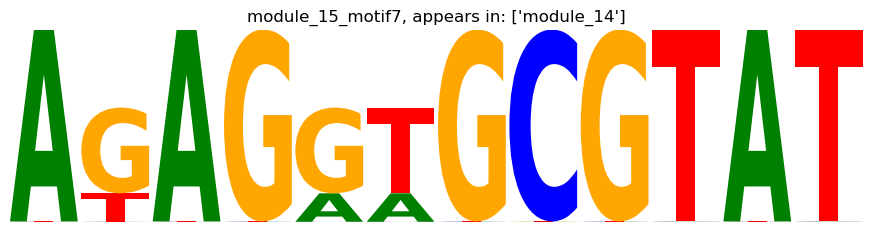

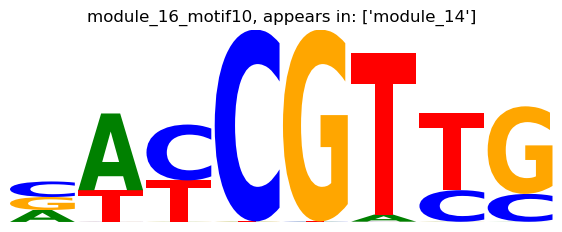

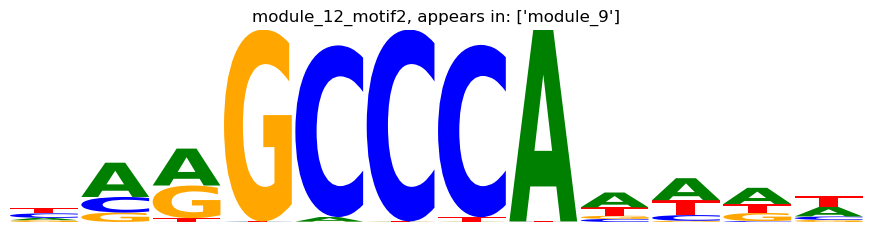

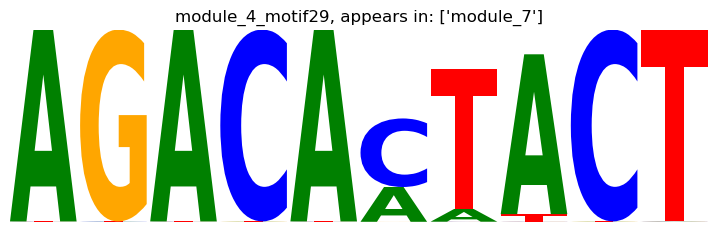

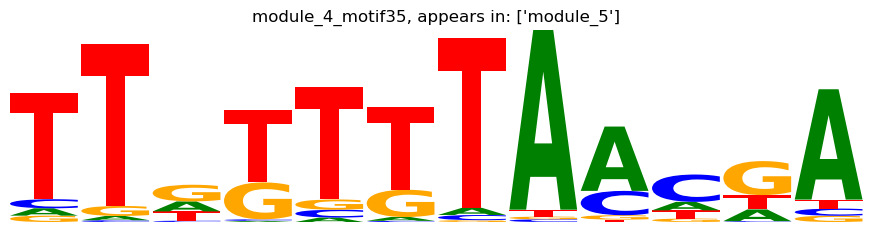

In [45]:
for motif, appears_in in motifs_sig_in_all.items():
    mod = '_'.join(motif.split('_')[:2])
    motif_base = motif.split('_')[-1]
    # Get the binding
    motif_rep = load_binding(f'../data/outputs/ATL_CND_ShD_Leaf_timey_backgrounds/ATL_ShD_Leaf_vs_CND_ShD_Leaf/{mod}/CND/homerResults/{motif_base}.motif')
    # Plot
    motif_title = 'module_' + str(module_mapper[int(motif.split('_')[1])]) + '_' + motif.split('_')[2]
    appears_in_new = [f'module_{module_mapper[int(m.split("_")[1])]}' for m in appears_in]
    make_logo(motif_rep, motif_title, appears_in_new)